In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds

!pip install sentence-transformers
!pip install umap-learn
!pip install hdbscan

from sentence_transformers import SentenceTransformer
import umap
import hdbscan

     |████████████████████████████████| 79 kB 5.3 MB/s 
     |████████████████████████████████| 4.2 MB 29.6 MB/s 
     |████████████████████████████████| 1.2 MB 41.2 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |████████████████████████████████| 596 kB 46.6 MB/s 
     |████████████████████████████████| 6.6 MB 29.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=42c8ae0fd097f88da42ed24d5a2826107574cce463503ba1889f86cc1a33f155
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 88 kB 4.9 MB/s 
     |████████████████████████████████| 1.1 MB 12.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-no

In [ ]:
from functools import reduce
import re
import string

import pandas.io.sql as sqlio   # DB  -> dataframe
from pandas import read_csv     # csv -> dataframe

from nltk.stem.snowball import SnowballStemmer


class StemmerWrapper:
    """ Class wrapper to some language stemmer; Via wrapping, I think,
        it is comfortable to operate with stemmer and functions,
        that formats text for systems.
    """
    def __init__(self, lang="russian"):
        """
        :param lang: Initializing stemmer with setting `lang` language
        """
        self.stemmer = SnowballStemmer(lang)

    def stem(self, *args, **kwargs):
        """ just for beauty and comfortable call"""
        return self.stemmer.stem(*args, **kwargs)

    @staticmethod
    def clean_string(sample_s: str) -> str:
        """
        :param sample_s: string to be formatted
        :return: formatted string
        formats given string by removing unnecessary components for
        building recommendation systems
        """
        # string to lowercase
        sample_s = sample_s.strip().lower()
        # removing one-symbol words
        sample_s = re.sub(r'\b[ЁёА-я]{1}\b', '', sample_s)
        # removing punctuation
        sample_s = re.sub(r'[%s]' % re.escape(string.punctuation), ' ',
                          sample_s)
        # removing one-digit numbers
        sample_s = re.sub(r'\b[0-9]{1}\b', '', sample_s)
        # replacing several-in-a-row space symbols with only one space
        sample_s = re.sub(r'\s+', ' ', sample_s)
        return sample_s.strip()


class Loader:
    """
    Class represents data-loader for systems. This is a base-class,
    so some virtual function must be overwritten.
    """
    def __init__(self, stemmer):
        """
        :param stemmer: language stemmer to be used
        """
        self.stemmer = stemmer

    def merge_contents(self,
                       table: str,
                       main_id: str,
                       content_cname: str,
                       columns: list):
        """
        merges content of selected `columns` from `table`;
        check overwritten function for more info.
        """
        pass

    @staticmethod
    def split_series(series):
        """
        :return: (pd.core.series.Series) updated `series`-copy
        :param series: (pd.core.series.Series)
        Splitting values in cell's of column `series` (in-place)
        """
        # handling None values separately
        return series.apply(lambda x: x.split() if type(x) == str else [])

    def format_columns(self,
                       dataframe,
                       main_id_cname: str,
                       content_cname: str,
                       columns: list):
        """
        :param dataframe: contains data to be formatted and used
        :param main_id_cname: item-representing-column's name
        :param content_cname: content-representing-column's name
        :param columns: names of columns in dataframe
        :return: 2-column dataframe, named as main_id_cname and
            content_cname; second columns contains formatted
            and merged `columns` content
        """
        # initializing new column in dataframe with empty strings
        dataframe[content_cname] = ''

        # remember items-id-representing column
        id_series = dataframe[main_id_cname]

        # set dataframe to a `columns`-containing table,
        # where all string infos was split into lists
        dataframe = dataframe[[content_cname] + columns].apply(
                self.split_series)

        # formatting all rows
        # firstly, we put add all lists to content containing column
        dataframe[content_cname] = reduce(
                lambda prev, el: prev + dataframe[el],
                columns,
                dataframe[content_cname]
        ).apply(  # then we would stem all words in this column
                lambda iterable: [self.stemmer.stem(w) for w in iterable]
        ).apply(  # lastly, we join lists to string
                lambda iterable: ' '.join(iterable)
        ).apply(
                StemmerWrapper.clean_string
        )

        # set item-representing-column's data
        dataframe[main_id_cname] = id_series

        # return table representing relationship item
        return dataframe[[main_id_cname, content_cname]]

    def parse(self, table: str, columns: list):
        """
        parses selected `columns` from `table`;
        check overwritten function for more info.
        """
        pass


class DataBaseLoader(Loader):
    """
    Represents data-loader from postgresql-database
    """
    def __init__(self, stemmer, connection):
        """
        :param stemmer: language stemmer to be used
        :param connection: connection to database
            (only SELECT command will be used my class)
        """
        super().__init__(stemmer)
        self.connection = connection

    def merge_contents(self,
                       table: str,
                       main_id_cname: str,
                       content_cname: str,
                       columns: list):
        """
        :param table: (str) table name, where from data will be read
        :param main_id_cname: (str) item-representing-column's name;
            it is explicit for `table` to have such column
        :param content_cname: (str) content-representing-column's name
        :param columns: (list) columns containing main content,
            that will be used to build a content-based model
        :return: (pd.core.frame.DataFrame) 2-column dataframe
            representing relationship of item and it's content
            (one-to-one relationship)
        """
        return self.format_columns(
                self.parse(table,
                           columns + [main_id_cname]),
                main_id_cname,
                content_cname,
                columns
        )

    def parse(self, table: str, columns: list):
        """
        :param table: database table name
        :param columns: columns to be parsed
        :return: dataframe with parsed columns
        """
        sql = "select {0} from {1};".format(
                ','.join(columns),
                table
        )
        return sqlio.read_sql_query(
                sql,
                self.connection
        )


class CsvLoader(Loader):
    """
    Represents data-loader from csv-file
    """
    def __init__(self, stemmer):
        """
        :param stemmer: language stemmer to be used
        """
        super().__init__(stemmer)

    def merge_contents(self,
                       path: str,
                       main_id_cname: str,
                       content_cname: str,
                       columns: list):
        """
        :param path: (str) path to table, where from data will be read
        :param main_id_cname: (str) item-representing-column's name;
            it is explicit for `path` to have such column
        :param content_cname: (str) content-representing-column's name
        :param columns: (list) columns containing main content,
            that will be used to build a content-based model
        :return: (pd.core.frame.DataFrame) 2-column dataframe
            representing relationship of item and it's content
            (one-to-one relationship)
        """
        return self.format_columns(
                self.parse(path, columns + [main_id_cname]),
                main_id_cname,
                content_cname,
                columns
        )

    def parse(self, table: str, columns: list):
        """
        :param table: database table name
        :param columns: columns to be parsed
        :return: dataframe with parsed columns
        """
        return read_csv(
                table,
                skipinitialspace=True,
                usecols=columns
        )


In [ ]:
class DataClusterizer:
    def __init__(self,
                 stemmer):
        # using stemmer
        self.stemmer = stemmer
        # similarity matrix (items_count x items_count)
        self.df_data = None
        # item-representing and content columns names
        self.item_id_cname = None
        self.content_cname = None

        self.embeddings = None
        self.cluster = None

    def set_data(self,
                 data, *args):
        self.df_data = data
        if args:
            self.item_id_cname, self.content_cname = args
        else:
            self.item_id_cname, self.content_cname = data.columns

    def load(self,
             table: str,
             item_id_cname: str,
             content_cname: str,
             content_columns: list,
             loader_type: str = "csv",
             connection=None):
        """
        :param table: table name where from data will be read (this
            either table of database or path to csv file, depending
            on loader_typ)
        :param item_id_cname: item-representing-column's name
        :param content_cname: content-representing-column's name
        :param content_columns: columns, which contents will be used
            to build model
        :param loader_type: equals either to "csv" or "db", depending
            on `table`
        :param connection: if loader_type equals to db, it must be
            connection to using database (otherwise - whatever)

        Loads data necessary to build model
        """
        self.item_id_cname = item_id_cname
        self.content_cname = content_cname
        if loader_type == "csv":
            loader = loaders.CsvLoader(self.stemmer)
        elif loader_type == "db":
            if connection is None:
                raise RuntimeError("SearchEngine::load: received connection "
                                   "equals to None with a loader_type equals "
                                   "db")
            loader = loaders.DataBaseLoader(self.stemmer, connection)
        else:
            raise RuntimeError("SearchEngine::load: no loader available for "
                               "given loader_type")
        self.df_data = loader.merge_contents(
                table,
                self.item_id_cname,
                content_cname,
                content_columns
        )

    def build(self,
              n_components=5,
              min_cluster_size=15,
              data=None):
        # extracting data structure
        if data is None:
            data = self.df_data[self.content_cname]

        # getting texts embeddings
        model = SentenceTransformer('distilbert-base-nli-mean-tokens')
        # you can run encoding with argument show_progress_bar=True
        self.embeddings = model.encode(data)

        # decreasing dimensions of embeddings
        # target dimensionality must be given to `n_components`
        # and local neighbourhood
        umap_embeddings = umap.UMAP(
                n_neighbors=n_components,
                n_components=5,
                metric='cosine'
        ).fit_transform(self.embeddings)
        # clustering data
        self.cluster = hdbscan.HDBSCAN(
                min_cluster_size=min_cluster_size,
                metric='euclidean',
                cluster_selection_method='eom'
        ).fit(umap_embeddings)

    def visualize(self):
        """
        Run method after building cluster
        """
        # decreasing dimensions of embeddings to 2,
        # so we can represent it in graphic
        umap_data = umap.UMAP(
                n_neighbors=15,
                n_components=2,
                min_dist=0.0,
                metric='cosine'
        ).fit_transform(self.embeddings)

        result = pd.DataFrame(umap_data, columns=['x', 'y'])
        result['labels'] = self.cluster.labels_

        # Visualize clusters
        fig, ax = plt.subplots(figsize=(20, 10))
        # texts that could be clustered
        outliers = result.loc[result.labels == -1, :]
        # clustered texts
        clustered = result.loc[result.labels != -1, :]
        plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
        plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
        plt.colorbar()

    def form_items_labels_pd(self):
        return self.cluster.labels_

    def get_item_category(self,
                          item):
        results = self.cluster.labels_[self.df_data.index[self.df_data[self.item_id_cname] == item]]
        if results:
            return results[0]
        return None

    def get_items_in_category(self,
                              topic_id):
        items_indices = np.argwhere(dc.cluster.labels_ == topic_id).T[0]
        return self.df_data[self.item_id_cname].iloc[items_indices]


In [ ]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train')['data']

In [ ]:
train = pd.DataFrame(train)
train['id'] = range(1, len(train) + 1)
train.head()

,0,id
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,1
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,2
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,3
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,4
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,5


In [ ]:
ws = StemmerWrapper()
dc = DataClusterizer(stemmer=ws)
dc.set_data(train, 'id', 0)    

In [ ]:
dc.build()

Batches:   0%|          | 0/354 [00:00<?, ?it/s]

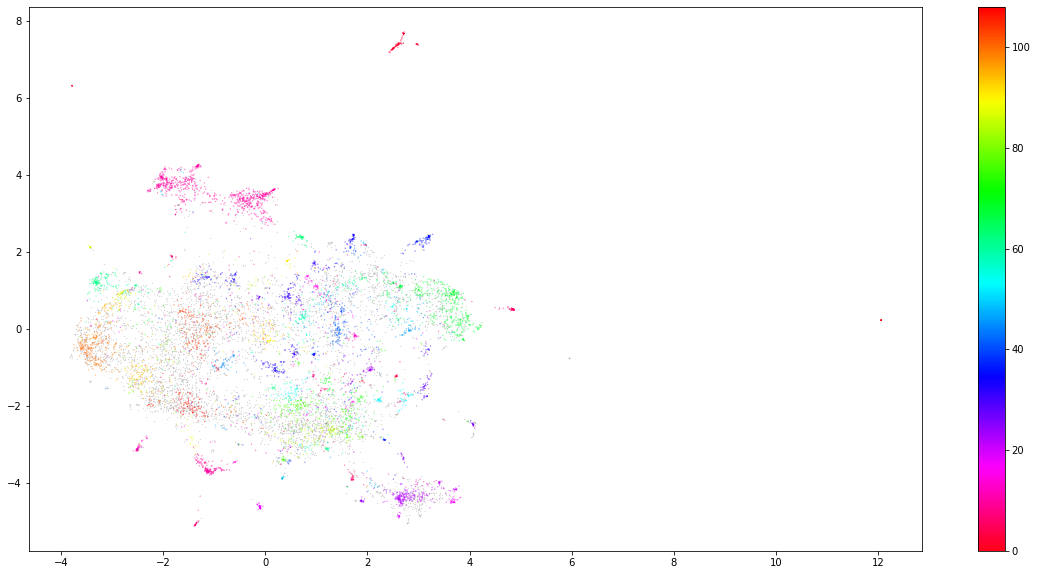

In [ ]:
dc.visualize()

In [ ]:
category = dc.get_item_category(1)

In [ ]:
dc.cluster.labels_[0]

88

In [ ]:
items_ids = np.argwhere(dc.cluster.labels_ == category[0]).T[0]

In [ ]:
res = dc.df_data[dc.item_id_cname].iloc[items_ids]

In [ ]:
res

0            1
405        406
492        493
876        877
904        905
958        959
1363      1364
1625      1626
2496      2497
2648      2649
2663      2664
2845      2846
3788      3789
3841      3842
4246      4247
4456      4457
4600      4601
4613      4614
5151      5152
5429      5430
5629      5630
5721      5722
6176      6177
6231      6232
6268      6269
6819      6820
7021      7022
7059      7060
7175      7176
7231      7232
8266      8267
8283      8284
8735      8736
8742      8743
8992      8993
9046      9047
9498      9499
10169    10170
10576    10577
10685    10686
10866    10867
11003    11004
11014    11015
Name: id, dtype: int64

In [ ]:
category[0]

88